In [498]:
import tensorflow as tf
import pandas as pd

In [514]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [500]:
df = df.drop(columns=['airline','tweet_id','name','negativereason_gold','tweet_coord','airline_sentiment_gold','airline_sentiment_confidence','negativereason','tweet_created','negativereason_confidence','tweet_location','user_timezone','retweet_count'])

In [501]:
df.tail()

,airline_sentiment,text
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."
14639,neutral,@AmericanAir we have 8 ppl so we need 2 know h...


In [502]:
sentiment = pd.get_dummies(df.airline_sentiment)
new_df = pd.concat([df,sentiment], axis=1)
new_df = new_df.drop(columns='airline_sentiment')
new_df.head()

,text,negative,neutral,positive
0,@VirginAmerica What @dhepburn said.,0,1,0
1,@VirginAmerica plus you've added commercials t...,0,0,1
2,@VirginAmerica I didn't today... Must mean I n...,0,1,0
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0


In [503]:
comment=new_df['text'].values
sentiment=new_df[['negative', 'neutral', 'positive']].values

In [504]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(comment, sentiment, test_size=0.2)

In [505]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ambil stopwords dari NLTK
stop_words = set(stopwords.words('english'))

# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000, oov_token='X')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

# Konversi teks ke sequences
sequen_train = tokenizer.texts_to_sequences(X_train)
sequen_test = tokenizer.texts_to_sequences(X_test)

# Hapus stopwords dari sequences
filtered_train = []
for sequence in sequen_train:
    filtered_sequence = [word for word in sequence if word not in stop_words]
    filtered_train.append(filtered_sequence)

filtered_test = []
for sequence in sequen_test:
    filtered_sequence = [word for word in sequence if word not in stop_words]
    filtered_test.append(filtered_sequence)

# Padding sequences
padded_train = pad_sequences(filtered_train)
padded_test = pad_sequences(filtered_test)


In [506]:
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.models import Sequential

model = Sequential([
    Embedding(input_dim=5000, output_dim=8),
    LSTM(32, dropout=0.5, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.8),
    Dense(32, activation='relu'),
    Dropout(0.8),
    Dense(3, activation='softmax')
])


In [507]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 8)           40000     
                                                                 
 lstm_39 (LSTM)              (None, 32)                5248      
                                                                 
 dense_117 (Dense)           (None, 64)                2112      
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_118 (Dense)           (None, 32)                2080      
                                                                 
 dropout_63 (Dropout)        (None, 32)                0         
                                                                 
 dense_119 (Dense)           (None, 3)               

In [508]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [509]:
history = model.fit(padded_train, y_train,
                    epochs=20,
                    validation_data=(padded_test,y_test),
                    verbose=2)

Epoch 1/20
366/366 - 64s - loss: 0.9129 - accuracy: 0.6130 - val_loss: 0.7246 - val_accuracy: 0.6370 - 64s/epoch - 176ms/step
Epoch 2/20
366/366 - 12s - loss: 0.7708 - accuracy: 0.6424 - val_loss: 0.6609 - val_accuracy: 0.7155 - 12s/epoch - 33ms/step
Epoch 3/20
366/366 - 12s - loss: 0.6871 - accuracy: 0.6795 - val_loss: 0.6070 - val_accuracy: 0.7278 - 12s/epoch - 33ms/step
Epoch 4/20
366/366 - 12s - loss: 0.6452 - accuracy: 0.7021 - val_loss: 0.5990 - val_accuracy: 0.7510 - 12s/epoch - 32ms/step
Epoch 5/20
366/366 - 12s - loss: 0.6048 - accuracy: 0.7223 - val_loss: 0.6069 - val_accuracy: 0.7517 - 12s/epoch - 33ms/step
Epoch 6/20
366/366 - 12s - loss: 0.5936 - accuracy: 0.7351 - val_loss: 0.6000 - val_accuracy: 0.7684 - 12s/epoch - 32ms/step
Epoch 7/20
366/366 - 12s - loss: 0.5814 - accuracy: 0.7406 - val_loss: 0.5873 - val_accuracy: 0.7698 - 12s/epoch - 33ms/step
Epoch 8/20
366/366 - 12s - loss: 0.5636 - accuracy: 0.7501 - val_loss: 0.6148 - val_accuracy: 0.7705 - 12s/epoch - 33ms/step

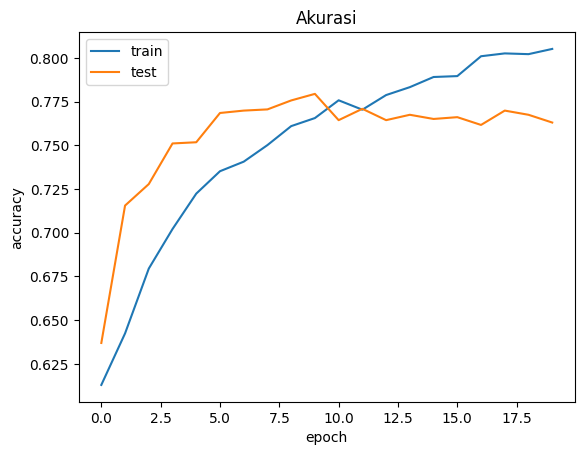

In [510]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

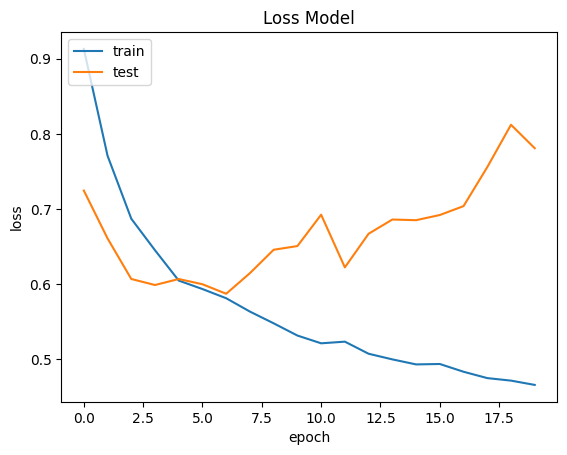

In [512]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch'),
plt.legend(['train', 'test'], loc='upper left')
plt.show()